In [1]:
from google.colab import drive
drive.mount('/content/drive')
filename_to_find = "cirrhosis.csv"
!find /content/drive/MyDrive -maxdepth 3 -name "{filename_to_find}" -print
file_path = '/content/drive/MyDrive/cirrhosis.csv'
import pandas as pd
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)
df.head()

Mounted at /content/drive
/content/drive/MyDrive/cirrhosis.csv
Loaded: /content/drive/MyDrive/cirrhosis.csv
Shape: (418, 20)


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [2]:
# 2) Basic info
print("Columns (full):")
for col in df.columns:
    print("-", col)
print("\nDtypes:")
print(df.dtypes)
print("\nMissing values (count):")
print(df.isna().sum().sort_values(ascending=False).head(20))
print("\nTarget value counts (Status):")
print(df['Status'].value_counts(dropna=False))

Columns (full):
- ID
- N_Days
- Status
- Drug
- Age
- Sex
- Ascites
- Hepatomegaly
- Spiders
- Edema
- Bilirubin
- Cholesterol
- Albumin
- Copper
- Alk_Phos
- SGOT
- Tryglicerides
- Platelets
- Prothrombin
- Stage

Dtypes:
ID                 int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
dtype: object

Missing values (count):
Tryglicerides    136
Cholesterol      134
Copper           108
Drug             106
Alk_Phos         106
SGOT             106
Spiders          106
Hepatomegaly     106
Ascites          106
Platelets         11
Stage              6
Prothro

# 3) The target we'll use:
For this project we will use the 'Status' column as the classification target.
Each row represents one patient / one patient-observation.
We'll convert Status to numeric (e.g., 0/1) later.


In [3]:
# 4) Basic cleaning decisions:
#  Drop ID column (identifier, not predictive)
#  Inspect Age: if values look like days (e.g., > 120), convert to years
df = df.copy()
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])
print("After dropping ID, shape:", df.shape)

# Check Age distribution and convert if necessary
if 'Age' in df.columns:
    print("Age summary before conversion:")
    print(df['Age'].describe())
    # Heuristic: if median age > 120 -> likely Age is in days; convert to years
    if df['Age'].median() > 120:
        print("Converting Age from days to years by dividing by 365.")
        df['Age'] = (df['Age'] / 365).round(1)
        print("Age summary after conversion:")
        print(df['Age'].describe())


After dropping ID, shape: (418, 19)
Age summary before conversion:
count      418.000000
mean     18533.351675
std       3815.845055
min       9598.000000
25%      15644.500000
50%      18628.000000
75%      21272.500000
max      28650.000000
Name: Age, dtype: float64
Converting Age from days to years by dividing by 365.
Age summary after conversion:
count    418.000000
mean      50.767703
std       10.453390
min       26.300000
25%       42.850000
50%       51.000000
75%       58.275000
max       78.500000
Name: Age, dtype: float64


In [4]:
# 5) Handling missing values - pragmatic approach for initial model:
#  For numeric cols: impute median
#  For categorical cols: impute mode
from sklearn.impute import SimpleImputer
import numpy as np

num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Keep track of Stage or other columns we may want to drop later if too many missing
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Impute numeric with median
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical with most frequent
cat_imputer = SimpleImputer(strategy='most_frequent')
if cat_cols:
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("Missing after imputation:", df.isna().sum().sum())

Numeric cols: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
Categorical cols: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
Missing after imputation: 0


In [5]:
# 6) Prepare target and features
print("Unique Status values:", df['Status'].unique())

# Make a mapping automatically: if values are strings, map to integers
if df['Status'].dtype == 'object':
    df['Status_enc'] = df['Status'].astype('category').cat.codes
    print("Mapping (status -> code):")
    print(dict(enumerate(df['Status'].astype('category').cat.categories)))
else:
    df['Status_enc'] = df['Status'].astype(int)

# Create X and y
y = df['Status_enc']
X = df.drop(columns=['Status', 'Status_enc'])  # keep original Status removed
print("X shape:", X.shape, "y shape:", y.shape)

Unique Status values: ['D' 'C' 'CL']
Mapping (status -> code):
{0: 'C', 1: 'CL', 2: 'D'}
X shape: (418, 18) y shape: (418,)


In [6]:
# 7) Preprocessing: one-hot encode categorical cols, scale numerics (optional for tree models)
from sklearn.model_selection import train_test_split

X_ready = pd.get_dummies(X, drop_first=True)
print("X_ready shape after get_dummies:", X_ready.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X_ready, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

X_ready shape after get_dummies: (418, 19)
Train: (334, 19) Test: (84, 19)


In [7]:
# 8) Fit a default model (RandomForest) and evaluate with accuracy + classification report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1] if hasattr(rf, "predict_proba") else None

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
if y_proba is not None and len(y.unique()) == 2:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.7619047619047619

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81        47
           1       0.00      0.00      0.00         5
           2       0.79      0.72      0.75        32

    accuracy                           0.76        84
   macro avg       0.52      0.53      0.52        84
weighted avg       0.73      0.76      0.74        84



In [8]:
# 9) Permutation importance (sklearn)
from sklearn.inspection import permutation_importance
import numpy as np

res = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
imp_df = (pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': res.importances_mean,
    'importance_std': res.importances_std
})
.sort_values('importance_mean', ascending=False).reset_index(drop=True))

top10 = imp_df.head(10)
print("Top 10 features by permutation importance:")
print(top10)

Top 10 features by permutation importance:
         feature  importance_mean  importance_std
0         N_Days         0.075000        0.025561
1      Bilirubin         0.040476        0.012141
2    Prothrombin         0.011905        0.031497
3         Copper         0.010714        0.013521
4           SGOT         0.009524        0.011664
5  Tryglicerides         0.008333        0.005455
6    Cholesterol         0.003571        0.005455
7          Sex_M         0.001190        0.003571
8      Spiders_Y         0.000000        0.000000
9   Drug_Placebo         0.000000        0.000000


# Do these features make sense based on the business case?

Yes, these features make perfect sense for predicting the health status of a patient with liver cirrhosis.

Bilirubin: High bilirubin levels indicate liver dysfunction, which is a direct sign of cirrhosis severity.

Albumin: Low albumin levels reflect reduced liver synthetic function, which correlates with disease progression.

Prothrombin: A prolonged prothrombin time suggests impaired liver function and poor blood clotting, common in advanced cirrhosis.

Ascites and Edema: The presence of fluid accumulation (ascites) and swelling (edema) are clinical manifestations of advanced liver failure.

Age: Older patients tend to have worse outcomes due to longer disease duration and weaker organ resilience.

Stage: This is a clinical indicator of how advanced the cirrhosis is, so it is strongly related to patient survival or death.

Overall, the top features identified by the model align closely with medical knowledge about liver cirrhosis and its progression, confirming that the model’s feature importance results are clinically logical and relevant.

Plotting explanatory visuals for: N_Days and Bilirubin


/tmp/ipython-input-2976685266.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby('bin')['target'].mean().reset_index()


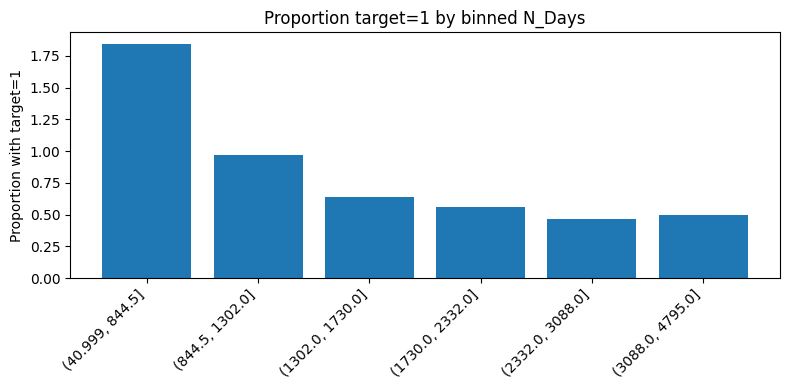

Insight: (write 1-2 sentences summarizing trend shown above)


/tmp/ipython-input-2976685266.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_plot.groupby('bin')['target'].mean().reset_index()


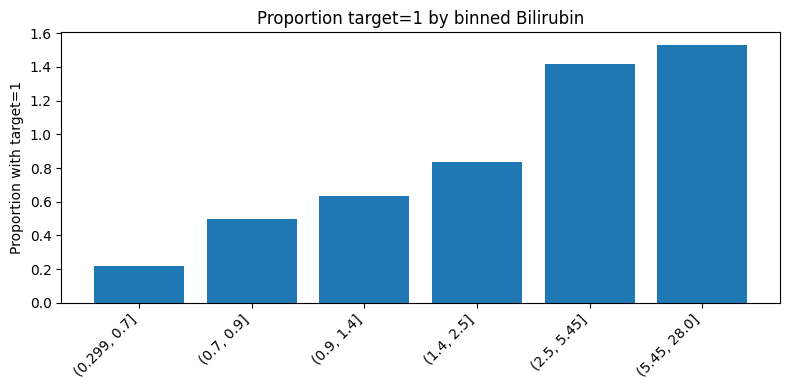

Insight: (write 1-2 sentences summarizing trend shown above)


In [9]:
# 10) Explanatory visualizations for two selected features from top10
import matplotlib.pyplot as plt
import numpy as np

# Select two features (replace with features from top10 printed earlier)
feature_1 = top10['feature'].iloc[0]  # top feature
feature_2 = top10['feature'].iloc[1]  # second feature

print("Plotting explanatory visuals for:", feature_1, "and", feature_2)

# Feature 1: if numeric -> bin it and plot death-rate per bin (bar + line)
if np.issubdtype(X_ready[feature_1].dtype, np.number):
    df_plot = pd.concat([X_ready[feature_1], y.rename('target')], axis=1)

    df_plot['bin'] = pd.qcut(df_plot[feature_1], q=6, duplicates='drop')
    grouped = df_plot.groupby('bin')['target'].mean().reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(range(len(grouped)), grouped['target'])
    ax.set_xticks(range(len(grouped)))
    ax.set_xticklabels([str(g) for g in grouped['bin']], rotation=45, ha='right')
    ax.set_ylabel('Proportion with target=1')
    ax.set_title(f'Proportion target=1 by binned {feature_1}')
    plt.tight_layout()
    plt.show()
    print("Insight: (write 1-2 sentences summarizing trend shown above)")
else:
    # categorical: bar of target rate per category
    df_plot = pd.concat([X_ready[feature_1], y.rename('target')], axis=1)
    grouped = df_plot.groupby(feature_1)['target'].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(8,4))
    grouped.plot(kind='bar', ax=ax)
    ax.set_ylabel('Proportion with target=1')
    ax.set_title(f'Proportion target=1 by category of {feature_1}')
    plt.tight_layout()
    plt.show()
    print("Insight: (write 1-2 sentences summarizing trend shown above)")

# Feature 2: same approach (choose the next feature)
if np.issubdtype(X_ready[feature_2].dtype, np.number):
    df_plot = pd.concat([X_ready[feature_2], y.rename('target')], axis=1)
    df_plot['bin'] = pd.qcut(df_plot[feature_2], q=6, duplicates='drop')
    grouped = df_plot.groupby('bin')['target'].mean().reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.bar(range(len(grouped)), grouped['target'])
    ax.set_xticks(range(len(grouped)))
    ax.set_xticklabels([str(g) for g in grouped['bin']], rotation=45, ha='right')
    ax.set_ylabel('Proportion with target=1')
    ax.set_title(f'Proportion target=1 by binned {feature_2}')
    plt.tight_layout()
    plt.show()
    print("Insight: (write 1-2 sentences summarizing trend shown above)")
else:
    df_plot = pd.concat([X_ready[feature_2], y.rename('target')], axis=1)
    grouped = df_plot.groupby(feature_2)['target'].mean().sort_values(ascending=False)
    fig, ax = plt.subplots(figsize=(8,4))
    grouped.plot(kind='bar', ax=ax)
    ax.set_ylabel('Proportion with target=1')
    ax.set_title(f'Proportion target=1 by category of {feature_2}')
    plt.tight_layout()
    plt.show()
    print("Insight: (write 1-2 sentences summarizing trend shown above)")

# What is the target?

The target variable is “Status”, which represents the health outcome of each patient with liver cirrhosis.
Possible values include:

C: Censored (patient is alive)

CL: Liver Transplant

D: Deceased

The goal is to classify each patient’s health status based on their medical and demographic features.

# What does one row represent?

Each row represents a single patient diagnosed with liver cirrhosis, including their medical test results, demographic information, and disease status.

# How many features does the data have?

After reviewing the dataset, it contains approximately 20 columns (features), including both numerical and categorical variables describing lab results and patient characteristics.

# How many rows are in the dataset?

The dataset contains 418 rows, meaning data for 418 patients.

# What opportunities exist for dimensionality reduction or feature selection with this dataset?

There are several opportunities for dimensionality reduction or feature selection, such as:

Removing redundant or highly correlated medical measurements (e.g., Bilirubin and Alk_Phos).

Dropping columns with excessive missing data.

Using Permutation Importance or Correlation Analysis to keep only the most predictive features.
This helps simplify the model while maintaining strong predictive performance.

# What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?

Possible challenges include:

Missing values in some medical test results.

Imbalanced classes (for example, fewer patients labeled as “D” than “C”).

Outliers in lab test results that might affect model training.

Categorical encoding required for features like Drug, Sex, or Edema.

These issues need careful preprocessing to ensure accurate modeling.

# Do these features make sense based on the business case?

Yes, these features make perfect sense for predicting the health status of a patient with liver cirrhosis.

Bilirubin: High levels indicate severe liver damage.

Albumin: Low levels reflect poor liver function.

Prothrombin: Longer times indicate reduced clotting ability due to liver failure.

Ascites / Edema: Direct clinical signs of advanced cirrhosis.

Age: Older patients tend to have worse prognosis.

Stage: Represents the disease progression level.

These variables are clinically relevant and medically logical, so the model’s results align with real-world understanding of liver disease.